# Van Der Pol Oscillator
The van der Pol equation is an ordinary differential equation that can be derived from the Rayleigh differential equation by differentiating and setting y=y'. It is an equation describing self-sustaining oscillations in which energy is fed into small oscillations and removed from large oscillations. This equation arises in the study of circuits containing vacuum tubes and is given by

\begin{align*}
y'' - \mu(1 - y^2)y' + y = 0
\end{align*}


To build a Van der Pol Oscillator model in Python, we'll use the Runge-Kutta 4th order method (RK4) to solve the oscillator's differential equations over time. This method provides a good balance between computational efficiency and the accuracy needed for simulating nonlinear systems like the Van der Pol oscillator. 


\begin{align*}
\frac{dy(t)}{dt} = y'(t) = f(y(t), t), \quad \text{with} \quad y(t_0) = y_0
\end{align*}

(starting from some known initial condition, y(t₀)=y₀). The development of the Fourth Order Runge-Kutta method closely follows those for the Second Order, and will not be covered in detail here. As with the second order technique there are many variations of the fourth order method, and they all use four approximations to the slope. We will use the following slope approximations to estimate the slope at some time t₀ (assuming we only have an approximation to y(t₀) (which we call y*(t₀)).

\begin{align*}
k_1 &= f(y^*(t_0), t_0) \\
k_2 &= f\left(y^*(t_0) + \frac{k_1 h}{2}, t_0 + \frac{h}{2}\right) \\
k_3 &= f\left(y^*(t_0) + \frac{k_2 h}{2}, t_0 + \frac{h}{2}\right) \\
k_4 &= f(y^*(t_0) + k_3 h, t_0 + h)
\end{align*}

[Fourth Order Runge-Kutta](https://lpsa.swarthmore.edu/NumInt/NumIntFourth.html)


## Ground Truth

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

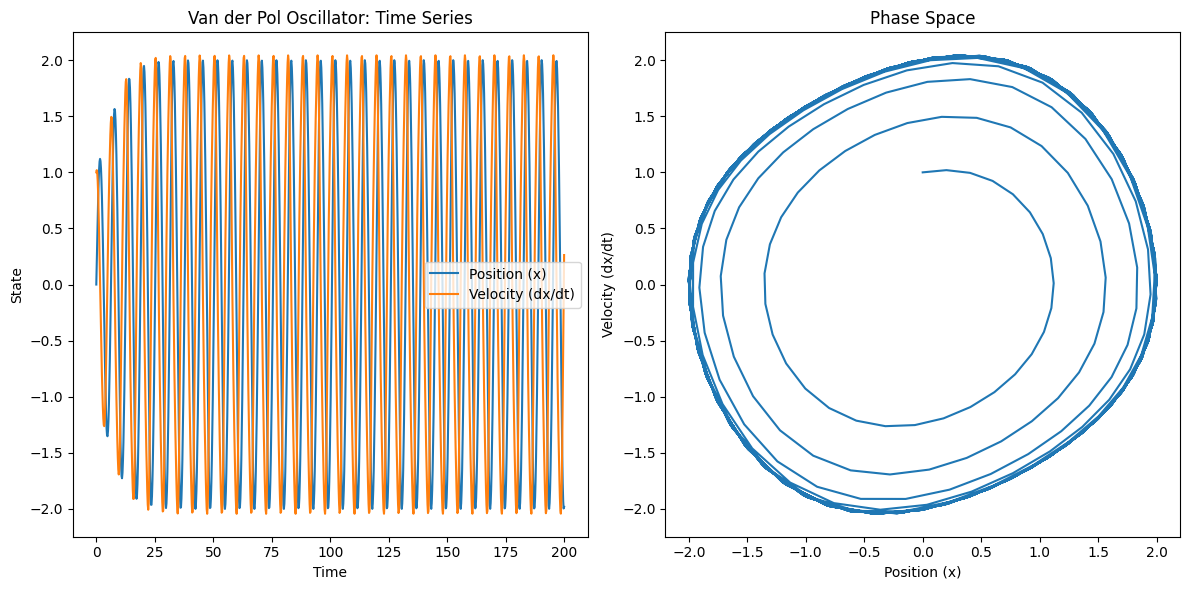

In [2]:
# Define the differential equations for the Van der Pol Oscillator
def van_der_pol_oscillator(t, y, mu):
    x, v = y  # y contains position and velocity
    dxdt = v
    dvdt = mu * (1 - x**2) * v - x
    return np.array([dxdt, dvdt])

# Implement the RK4 method
def rk4(t0, y0, t1, n, mu):
    dt = (t1 - t0) / n
    t = t0
    y = y0
    ys = [y0]
    ts = [t0]
    
    for _ in range(n):
        k1 = van_der_pol_oscillator(t, y, mu)
        k2 = van_der_pol_oscillator(t + dt / 2, y + dt / 2 * k1, mu)
        k3 = van_der_pol_oscillator(t + dt / 2, y + dt / 2 * k2, mu)
        k4 = van_der_pol_oscillator(t + dt, y + dt * k3, mu)
        
        y = y + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)
        t = t + dt
        ys.append(y)
        ts.append(t)
        
    return np.array(ts), np.array(ys)

# Simulation parameters
t0 = 0  # start time
t1 = 200  # end time
n = 1000  # number of steps
y0 = np.array([0.0, 1.0])  # initial condition (position, velocity)
mu = 0.2  # nonlinearity parameter

# Run the simulation
ts, ys = rk4(t0, y0, t1, n, mu)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(ts, ys[:, 0], label='Position (x)')
plt.plot(ts, ys[:, 1], label='Velocity (dx/dt)')
plt.title('Van der Pol Oscillator: Time Series')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ys[:, 0], ys[:, 1])
plt.title('Phase Space')
plt.xlabel('Position (x)')
plt.ylabel('Velocity (dx/dt)')

plt.tight_layout()
plt.show()


## EKF Prediction

In [3]:
def ekf_predict(x, P, Q, dt, mu):
    """
    EKF Prediction Step for the Van der Pol Oscillator.
    
    Parameters:
    - x: The state estimate vector at time t-1.
    - P: The covariance of the state estimate at time t-1.
    - Q: The process noise covariance matrix.
    - dt: Time step.
    - mu: Nonlinearity parameter of the Van der Pol oscillator.
    
    Returns:
    - x_pred: Predicted state estimate vector at time t.
    - P_pred: Predicted covariance of the state estimate at time t.
    """
    # State transition function (f) and Jacobian (F) of the Van der Pol oscillator
    A = np.array([[0, 1], [-1, mu*(1 - x[0]**2)]])
    F = np.eye(2) + A * dt  # Linear approximation
    
    # Predict state
    x_pred = x + np.array([x[1], mu * (1 - x[0]**2) * x[1] - x[0]]) * dt
    
    # Predict covariance
    P_pred = F @ P @ F.T + Q
    
    return x_pred, P_pred

def ekf_update(x_pred, P_pred, z, R, H):
    """
    EKF Update Step.
    
    Parameters:
    - x_pred: Predicted state estimate vector.
    - P_pred: Predicted covariance of the state estimate.
    - z: The measurement vector at time t.
    - R: The measurement noise covariance matrix.
    - H: The measurement matrix.
    
    Returns:
    - x_upd: Updated state estimate vector after incorporating measurement z.
    - P_upd: Updated covariance of the state estimate after incorporating measurement z.
    """
    # Measurement update
    S = H @ P_pred @ H.T + R  # Residual covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
    
    y = z - H @ x_pred  # Measurement residual
    x_upd = x_pred + K @ y
    P_upd = P_pred - K @ H @ P_pred
    
    return x_upd, P_upd

# Example usage
dt = 0.01  # Time step
mu = 0.2  # Nonlinearity parameter
x = np.array([0.0, 2.0])  # Initial state estimate
P = np.eye(2) * 0.1  # Initial state covariance
Q = np.eye(2) * 0.01  # Process noise covariance
R = np.eye(1) * 0.1  # Measurement noise covariance
H = np.array([[1, 0]])  # Measurement matrix

# Simulate a single predict-update cycle
x_pred, P_pred = ekf_predict(x, P, Q, dt, mu)
# Assuming a measurement of the position
z = np.array([1.95])  # Example measurement
x_upd, P_upd = ekf_update(x_pred, P_pred, z, R, H)

print("Updated State:", x_upd)
print("Updated Covariance:\n", P_upd)


Updated State: [1.03099614 2.00401838]
Updated Covariance:
 [[5.23832198e-02 9.52335603e-07]
 [9.52335603e-07 1.10410400e-01]]


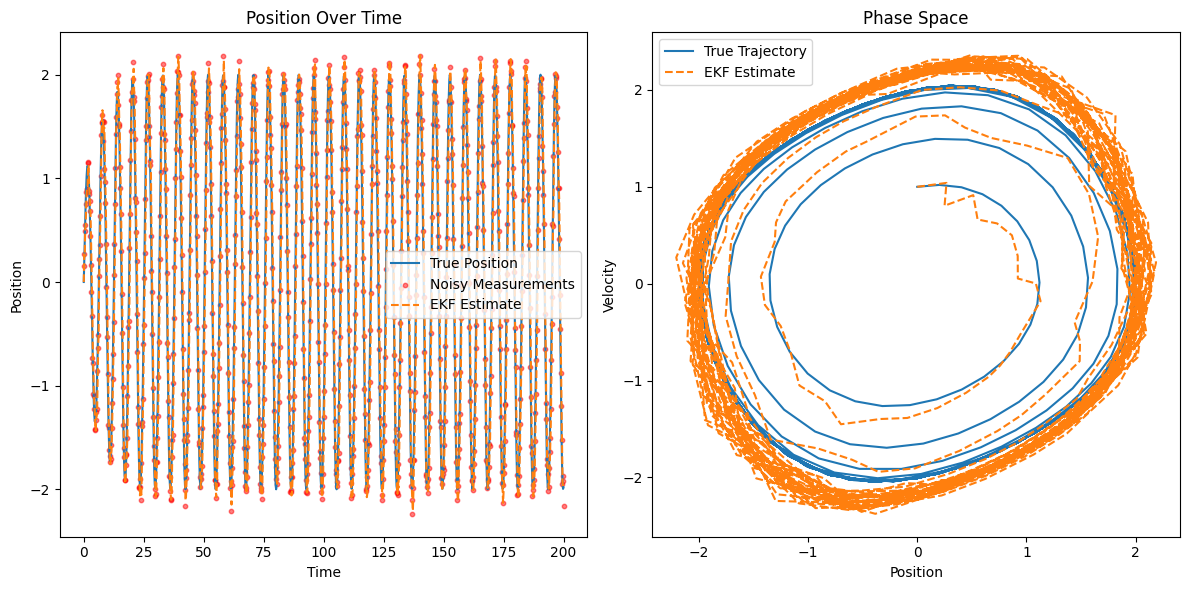

In [4]:
# Generate "true" trajectory with RK4
mu = 0.2
t0, t1, n = 0, 200, 1000
y0 = np.array([0.0, 1.0])
ts, true_ys = rk4(t0, y0, t1, n, mu)

# Simulate noisy measurements (only for position)
measurement_noise_std = 0.1
noisy_measurements = true_ys[:, 0] + np.random.normal(0, measurement_noise_std, size=true_ys[:, 0].shape)

# Initialize EKF
x_ekf = np.array([0.0, 1.0])  # Initial state estimate (same as true initial condition for simplicity)
P = np.eye(2) * 0.1  # Initial state covariance
Q = np.eye(2) * 0.01  # Process noise covariance
R = np.array([[measurement_noise_std ** 2]])  # Measurement noise covariance
H = np.array([[1, 0]])  # Measurement matrix

# Store EKF estimates for plotting
ekf_estimates = [x_ekf]

# EKF over multiple steps
for z in noisy_measurements:
    # Prediction step
    x_pred, P_pred = ekf_predict(x_ekf, P, Q, (t1-t0)/n, mu)
    
    # Update step with simulated measurement
    z_arr = np.array([z])  # Measurement vector
    x_upd, P_upd = ekf_update(x_pred, P_pred, z_arr, R, H)
    
    # Store update and prepare for next iteration
    ekf_estimates.append(x_upd)
    x_ekf, P = x_upd, P_upd

# Convert list of EKF estimates to array for plotting
ekf_estimates = np.array(ekf_estimates)

# Plotting
plt.figure(figsize=(12, 6))

# True trajectory and noisy measurements
plt.subplot(1, 2, 1)
plt.plot(ts, true_ys[:, 0], label='True Position')
plt.scatter(ts, noisy_measurements, s=10, color='red', label='Noisy Measurements', alpha=0.5)
plt.plot(ts, ekf_estimates[:-1, 0], label='EKF Estimate', linestyle='--')
plt.title('Position Over Time')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()

# Phase space - True vs. EKF Estimate
plt.subplot(1, 2, 2)
plt.plot(true_ys[:, 0], true_ys[:, 1], label='True Trajectory')
plt.plot(ekf_estimates[:-1, 0], ekf_estimates[:-1, 1], label='EKF Estimate', linestyle='--')
plt.title('Phase Space')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.legend()

plt.tight_layout()
plt.show()



## UFK Perdiction

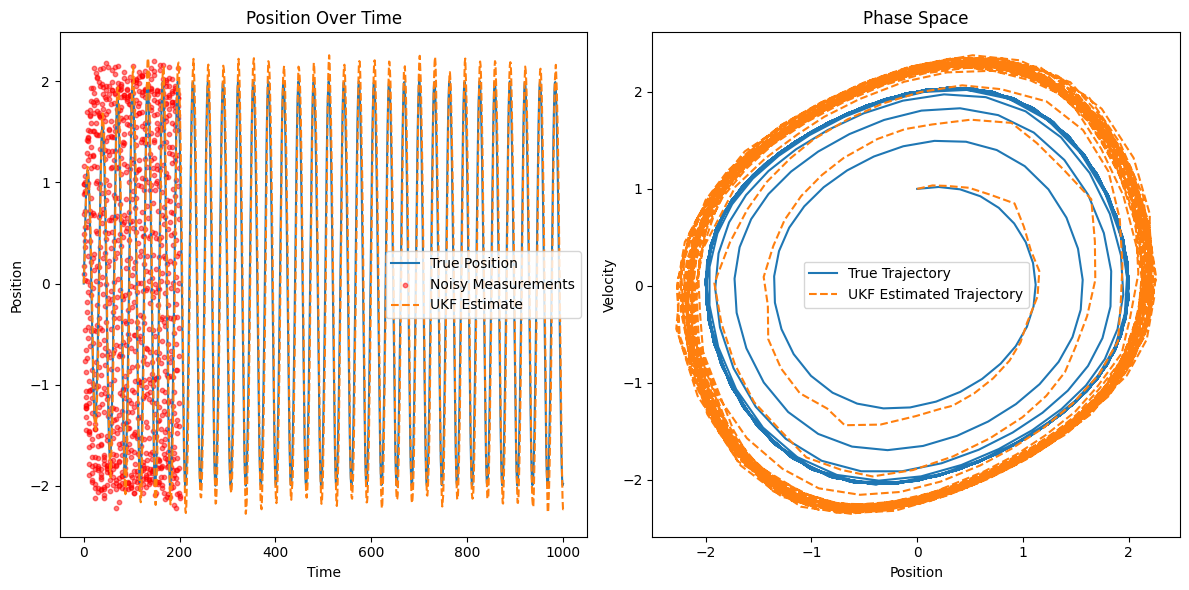

In [5]:
def van_der_pol_dynamics(y, dt, mu):
    """
    Simplified dynamics of the Van der Pol oscillator for sigma point propagation.
    """
    x, v = y  # Decompose state vector
    dxdt = v
    dvdt = mu * (1 - x**2) * v - x
    return np.array([x + dxdt * dt, v + dvdt * dt])
    
def generate_sigma_points(x, P, alpha, ki, beta):
    """
    Generate sigma points around the current estimate.
    """
    n = x.shape[0]
    lambda_ = alpha**2 * (n + ki) - n
    sigma_points = np.zeros((2 * n + 1, n))
    wm = np.zeros(2 * n + 1)
    wc = np.zeros(2 * n + 1)
    c = np.sqrt(n + lambda_)
    W = c * np.linalg.cholesky(P)
    sigma_points[0] = x
    for i in range(n):
        sigma_points[i + 1] = x + W[:, i]
        sigma_points[n + i + 1] = x - W[:, i]
    # Weights for mean and covariance
    wm.fill(1 / (2 * (n + lambda_)))
    wc.fill(1 / (2 * (n + lambda_)))
    wm[0] = lambda_ / (n + lambda_)
    wc[0] = lambda_ / (n + lambda_) + (1 - alpha**2 + beta)
    return sigma_points, wm, wc

def ukf_predict(sigma_points, wm, wc, Q, dt, mu):
    """
    Predict next state and covariance from sigma points.
    """
    n = sigma_points.shape[1]
    # Propagate sigma points through dynamics
    for i in range(sigma_points.shape[0]):
        sigma_points[i] = van_der_pol_dynamics(sigma_points[i], dt, mu)
    # Predicted state mean
    x_pred = np.dot(wm, sigma_points)
    # Predicted state covariance
    P_pred = Q.copy()
    for i in range(2 * n + 1):
        diff = sigma_points[i] - x_pred
        P_pred += wc[i] * np.outer(diff, diff)
    return x_pred, P_pred, sigma_points

def ukf_update(x_pred, P_pred, sigma_points, z, R, H, wm, wc):
    """
    Update state and covariance estimates based on measurement.
    """
    n = x_pred.shape[0]
    zs = np.dot(H, sigma_points_pred.T)

    # Calculate predicted measurement covariance (Pz) correctly
    z_pred = np.dot(wm, zs.T)  # Predicted measurement mean, ensuring correct matrix operations
    Pz = R.copy()
    for i in range(2 * n + 1):
        diff = zs[:, i] - z_pred
        Pz += wc[i] * np.outer(diff, diff)

    # Now, ensure Pxz calculation is aligned with the dimensions
    Pxz = np.zeros((n, H.shape[0]))  # Ensure correct dimensionality
    for i in range(2 * n + 1):
        Pxz += wc[i] * np.outer(sigma_points_pred[i] - x_pred, zs[:, i] - z_pred)
    K = np.dot(Pxz, np.linalg.inv(Pz))  # Kalman gain
    x_upd = x_pred + np.dot(K, (z - z_pred))  # Updated state estimate
    P_upd = P_pred - np.dot(K, np.dot(Pz, K.T))  # Updated covariance estimate
    return x_upd, P_upd

    
# Parameters
mu = 0.2
alpha = 1e-3  # Tuning parameter for sigma point spread
ki = 0        # Secondary scaling parameter (often 0 for UKF)
beta = 2      # Optimal for Gaussian distributions
dt = 200 / 1000  # Time increment
n = 1000       # Number of steps

# Initial conditions
x_ukf = np.array([0.0, 1.0])  # Initial state estimate
P_ukf = np.eye(2) * 0.1  # Initial covariance estimate
Q = np.eye(2) * 0.01  # Process noise covariance
R = np.array([[0.1]])  # Measurement noise covariance, assuming measurements are of position only
H = np.array([[1, 0]])  # Measurement matrix

# Generating synthetic noisy measurements from the true model
_, true_ys = rk4(0, x_ukf, 200, n, mu)
noisy_measurements = true_ys[:, 0] + np.random.normal(0, 0.1, n+1)  # Noisy position measurements

# UKF estimation process
ukf_estimates = [x_ukf]
for z in noisy_measurements:
    sigma_points, wm, wc = generate_sigma_points(x_ukf, P_ukf, alpha, ki, beta)
    x_pred, P_pred, sigma_points_pred = ukf_predict(sigma_points, wm, wc, Q, dt, mu)
    x_ukf, P_ukf = ukf_update(x_pred, P_pred, sigma_points_pred, np.array([z]), R, H, wm, wc)
    ukf_estimates.append(x_ukf)

ukf_estimates = np.array(ukf_estimates)

# Plotting results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(true_ys[:, 0], label='True Position')
plt.scatter(np.linspace(0, 200, n+1), noisy_measurements, color='red', s=10, alpha=0.5, label='Noisy Measurements')
plt.plot(ukf_estimates[:, 0], linestyle='--', label='UKF Estimate')
plt.title('Position Over Time')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(true_ys[:, 0], true_ys[:, 1], label='True Trajectory')
plt.plot(ukf_estimates[:, 0], ukf_estimates[:, 1], linestyle='--', label='UKF Estimated Trajectory')
plt.title('Phase Space')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.legend()

plt.tight_layout()
plt.show()


## EKF UFK Runtime and Accuracy Comparison 

In [6]:
def plot_filter_results(ts, true_ys, ekf_estimates, ukf_estimates):
    """
    Plot the results of the EKF and UKF alongside the true trajectory of the system.
    
    Parameters:
    - ts: Array of time steps.
    - true_ys: Array of the true states over time.
    - ekf_estimates: Array of the EKF estimated states over time.
    - ukf_estimates: Array of the UKF estimated states over time.
    """
    plt.figure(figsize=(14, 6))
    
    # Position over time
    plt.subplot(1, 2, 1)
    plt.plot(ts, true_ys[:, 0], label='True Position', color='black')
    plt.scatter(ts, true_ys[:, 0] + np.random.normal(0, 0.1, len(ts)), color='red', s=10, alpha=0.3, label='Noisy Measurements')
    plt.plot(ts, ekf_estimates[:, 0], label='EKF Estimate', linestyle='--', color='blue')
    plt.plot(ts, ukf_estimates[:, 0], label='UKF Estimate', linestyle='-.', color='green')
    plt.title('Position Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Position')
    plt.legend()

    # Phase space trajectory
    plt.subplot(1, 2, 2)
    plt.plot(true_ys[:, 0], true_ys[:, 1], label='True Trajectory', color='black')
    plt.plot(ekf_estimates[:, 0], ekf_estimates[:, 1], label='EKF Estimated Trajectory', linestyle='--', color='blue')
    plt.plot(ukf_estimates[:, 0], ukf_estimates[:, 1], label='UKF Estimated Trajectory', linestyle='-.', color='green')
    plt.title('Phase Space')
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [7]:
# Initialize lists for runtimes and differences
ekf_runtimes = []
ukf_runtimes = []
ekf_differences = []
ukf_differences = []

# Initialize estimates
ekf_estimates = [x_ekf.copy()]  # Ensure x_ekf is defined and copied as the initial state
ukf_estimates = [x_ukf.copy()]  # Ensure x_ukf is defined and copied as the initial state

# Perform filter updates
for i, z in enumerate(noisy_measurements):
    true_state = true_ys[i]  # Current true state for comparison

    # EKF cycle
    start_time_ekf = time.time()
    x_pred, P_pred = ekf_predict(ekf_estimates[-1], P, Q, (t1-t0)/n, mu)
    z_arr = np.array([z])  # Measurement vector
    x_upd, P_upd = ekf_update(x_pred, P_pred, z_arr, R, H)
    end_time_ekf = time.time()
    ekf_runtimes.append(end_time_ekf - start_time_ekf)
    
    if i > 0:
        ekf_estimates.append(x_upd)
        # Calculate and store the absolute difference for EKF
        ekf_diff = np.abs(x_upd - true_state).sum()  # Sum differences for all state dimensions
        ekf_differences.append(ekf_diff)

    # UKF cycle
    start_time_ukf = time.time()
    sigma_points, wm, wc = generate_sigma_points(ukf_estimates[-1], P_ukf, alpha, ki, beta)
    x_pred, P_pred, sigma_points_pred = ukf_predict(sigma_points, wm, wc, Q, dt, mu)
    x_upd, P_upd = ukf_update(x_pred, P_pred, sigma_points_pred, np.array([z]), R, H, wm, wc)
    end_time_ukf = time.time()
    ukf_runtimes.append(end_time_ukf - start_time_ukf)
    
    if i > 0:
        ukf_estimates.append(x_upd)
        # Calculate and store the absolute difference for UKF
        ukf_diff = np.abs(x_upd - true_state).sum()  # Sum differences for all state dimensions
        ukf_differences.append(ukf_diff)

# Summarize results
ekf_total_diff = np.sum(ekf_differences)
ukf_total_diff = np.sum(ukf_differences)
print("Total Absolute Difference for EKF:", ekf_total_diff)
print("Total Absolute Difference for UKF:", ukf_total_diff)
print("Average Runtime for EKF per Step:", np.mean(ekf_runtimes))
print("Average Runtime for UKF per Step:", np.mean(ukf_runtimes))

Total Absolute Difference for EKF: 500.66990713543316
Total Absolute Difference for UKF: 306.5364776568927
Average Runtime for EKF per Step: 1.9552705290315153e-05
Average Runtime for UKF per Step: 6.746745609736942e-05


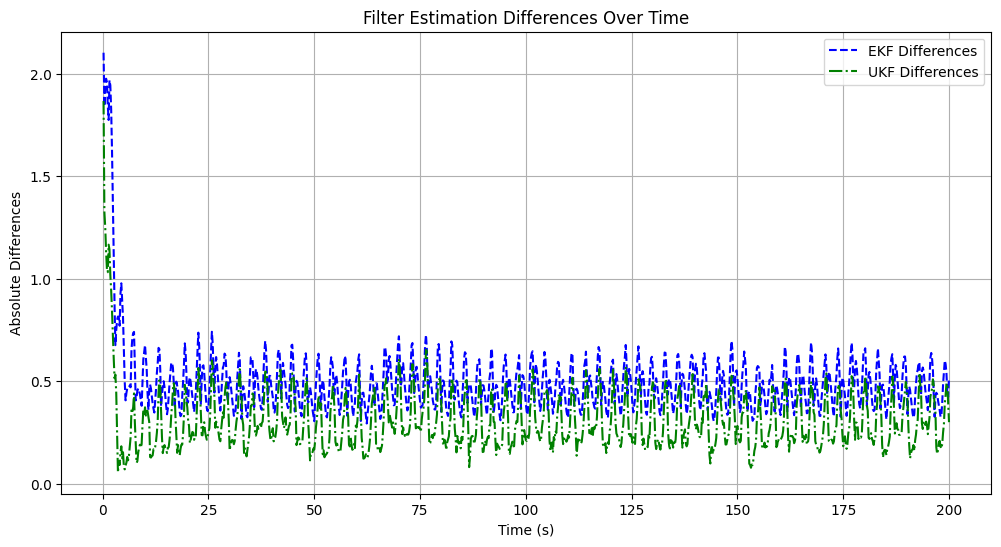

In [10]:
ts_adjusted = ts[1:]  # Adjusting time steps if necessary

# Define the plotting function for differences
def plot_estimation_differences(ts, ekf_diffs, ukf_diffs):
    plt.figure(figsize=(12, 6))
    plt.plot(ts, ekf_diffs, label='EKF Differences', color='blue', linestyle='--')
    plt.plot(ts, ukf_diffs, label='UKF Differences', color='green', linestyle='-.')
    plt.title('Filter Estimation Differences Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Absolute Differences')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting function
plot_estimation_differences(ts_adjusted, ekf_differences, ukf_differences)